In [4]:
# change working directory to be repo base
import os
# os.chdir('/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy')
os.chdir('../')

In [40]:
# import function file
import Yukawa_SINDy as ys
# import libraries
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
# ignore warnings generated from using LaTeX coding in matplotlib label strings
from warnings import filterwarnings
filterwarnings('ignore', message = 'invalid escape sequence')
# import scaling constant from working directory and declare as global variable
from pickle import load
with open('scaling_const.float','rb') as f:
    A = load(f)

In [127]:
def same_times(list_of_sims:list):
    '''
    Description: Helper function to check if all simulations in a list of 
    Yukawa_SINDy.Yukawa_simulation objs have the same time grid. returns 
    True or False.
    '''
    same_times:bool = True
    t_check = list_of_sims[0].t
    for sim in list_of_sims[1:]:
        if not np.all(t_check == sim.t):
            same_times = False
            break
    return same_times


def kfold_training(x_train:np.ndarray, t_data:np.ndarray, n_folds:int, SINDy_model:ps.SINDy, verbose:bool=False):
    '''
    Description: takes in training data and associated time data and performs k-fold
    cross-validation with k=n_folds. Takes in a ps.SINDy object to extract the library
    of terms, feature names, and optimizer. Prints all model if verbose is True.
    Returns rmse score from all models and a 3D array of coefficients from all models.
    '''
    # check dimension of training_data and t_data arrays
    if x_train.ndim!=3:
        raise Exception('training data has wrong dimensions')
    if x_train.shape[1]!=t_data.shape[0]:
        raise Exception('time data has wrong dimensions')
    # get SINDy parameters from input SINDy model
    feature_list = SINDy_model.get_feature_names()
    n_features = len(feature_list)
    feature_library = SINDy_model.feature_library
    feature_names = SINDy_model.feature_names
    opt = SINDy_model.optimizer

    # check if feature_library is weak or strong, don't need
    # to pass time as an arg into the 'fit' method of ps.SINDy
    if isinstance(feature_library, ps.WeakPDELibrary):
        t_to_fit = None
    else:
        t_to_fit = t_data
    
    # perform KFold CV
    all_rmse = np.array([])
    all_coefs = np.empty((0,x_train.shape[2],n_features))
    kf = KFold(n_splits=n_folds)
    for train, test in kf.split(x_train):
        # split training data
        x_train_kf = [traj for traj in x_train[train]]
        x_test_kf  = [traj for traj in x_train[test]]
        # print(f'train shape: {train.shape}')
        # print(f'test shape: {test.shape}')
        # fit SINDy model using given threshold
        mdl = ps.SINDy(optimizer=opt, feature_library=feature_library, feature_names=feature_names)
        mdl.fit(x_train_kf, t_to_fit, multiple_trajectories=True)
        if verbose: mdl.print()

        # get coefs and append to all_coefs
        coefs = mdl.coefficients()
        coefs = coefs.reshape((1,*coefs.shape))
        all_coefs = np.vstack((all_coefs,coefs))

        # validate model against test data
        # print(f'test traj shape: {x_test_kf[0].shape}') # included for testing
        # print(f'coefficients shape: {mdl.coefficients().shape}') # included for testing
        rmse = mdl.score(x_test_kf, t=t_data, multiple_trajectories=True, metric=root_mean_squared_error)
        all_rmse = np.hstack((all_rmse, rmse))

    # pull out coefs with the lowest error from cross val
    best_coefs = all_coefs[all_rmse.argmin()]
    
    # extract average model with average of all coef
    avg_coefs = coefs.mean(axis=0)

    return best_coefs, avg_coefs


def test_on_withhold(x_withhold:np.ndarray, feature_library:ps.feature_library.base.BaseFeatureLibrary, coefs:np.ndarray):
    '''
    Description: This function tests the SINDy model described by 'coefs' on multiple trajectories 
    data passed with 'x_withhold'. This is done by computing the rmse value between the prediction
    of x_dot generated by the SINDy model with the calculated x_dot using finite difference.
    '''
    n_features = x_withhold.shape[-1]
    lib_funcs = feature_library.functions
    lib_for_pred = ps.CustomLibrary(library_functions=lib_funcs)
    fd = ps.FiniteDifference()
    all_x_dot_pred = np.empty((0,n_features))
    all_x_dot_calc = np.empty_like(all_x_dot_pred)
    for traj in x_withhold:
        # predicted x_dot
        lib_for_pred.fit(traj)
        Phi = lib_for_pred.transform(traj)
        x_dot_pred = Phi@coefs.T
        all_x_dot_pred = np.array(np.vstack((all_x_dot_pred,x_dot_pred)))
        # calculated x_dot
        x_dot_calc = fd._differentiate(traj,t_data)
        all_x_dot_calc = np.array(np.vstack((all_x_dot_calc,x_dot_calc)))

    rmse = root_mean_squared_error(all_x_dot_calc,all_x_dot_pred)

    return rmse


def cross_validate(all_data:list, threshold:float, feature_library:ps.feature_library.base.BaseFeatureLibrary, feature_names, n_folds=10):
    '''
    Description: This function performs k-fold cross-validation (cv) with k specified by the 'n_folds'
    (default 10) argument. Gets help from the 'sklearn.model_selection.KFold' object. Takes a list 
    of Yukawa_SINDy.Yukawa_simulation objects, a SINDy STLSQ threshold, a feature library 
    ('pysindy.BaseFeatureLibrary' child objs), and feature names as args. Returns a rank 3 numpy
    array of coefficients from the best two models: the one with the lowest error and the average
    coefficients of all models generated during k-fold cv. Generates coefficients using the weak
    library and makes predictions using those coefficients and the strong library's 'transform'
    method.
    '''
    # check if list of sim objects
    for item in all_data:
        if not isinstance(item, ys.Yukawa_simulation):
            raise TypeError("Argument 'all_data' should be list of 'Yukawa_SINDy.Yukawa_simulation' objects")
    # check if all time grids are the same
    if not same_times(all_data):
        raise Exception("All simulations do not have the same time grid.")
    
    # extract data from sim objects
    x_data = np.array([sim.x for sim in all_data])
    t_data = all_data[0].t
    n_timesteps = t_data.shape[0]
    n_features = all_data[0].x.shape[1]
    # print(f'shape and ndims of t_data: {t_data.shape}, {t_data.ndim}') # included for testing

    # split data into withhold(testing) and training data
    n_trajectories = len(all_data)
    rng = np.random.default_rng(seed=10235783)
    withhold_idxs = rng.choice(x_data.shape[0], np.floor(0.25 * n_trajectories).astype(int), replace=False)
    withhold_idxs.sort()
    train_idxs = np.delete(np.arange(len(all_data)), withhold_idxs)
    x_train = x_data[train_idxs]
    x_withhold = x_data[withhold_idxs]

    # declare optimizer with given threshold
    opt = ps.STLSQ(threshold=threshold)

    # get number of terms in library
    rand_data = np.random.random((n_timesteps,n_features))
    test_mdl = ps.SINDy(optimizer=opt, feature_library=feature_library, feature_names=feature_names)
    test_mdl.fit(rand_data)

    # perform kfold cv
    best_coefs, avg_coefs = kfold_training(x_train,t_data,n_folds,test_mdl)

    # delete unnecessary vars
    del test_mdl, rand_data

    best_rmse = test_on_withhold(x_withhold, feature_library, best_coefs)
    avg_rmse = test_on_withhold(x_withhold, feature_library, avg_coefs)
    
    return best_coefs, best_rmse, avg_coefs, avg_rmse


In [90]:
sims = ys.generate_training_data(noise_level=0.1,scaled=True)

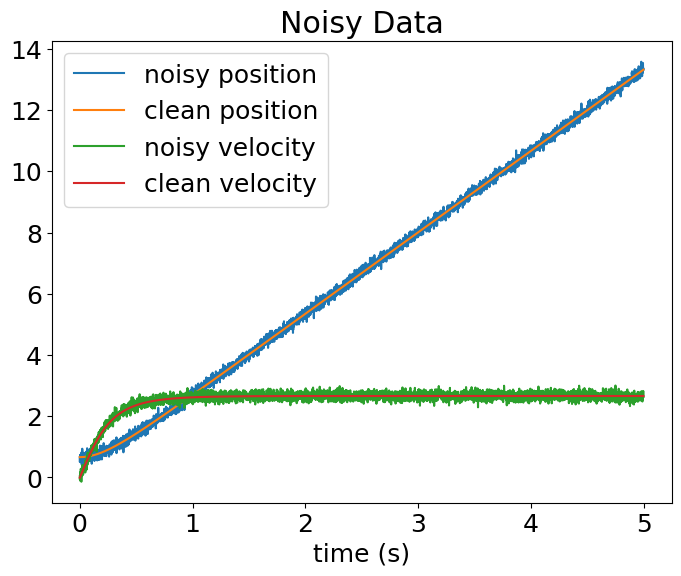

In [91]:
sims[10].plot()

In [124]:
threshold = 0.3*A
t_data = sims[0].t
weak_lib, strong_lib = ys.generate_libraries(t_data)
feature_names = ['x', 'v']

best_coefs, best_rmse, avg_coefs, avg_rmse = cross_validate(sims, threshold, weak_lib, feature_names)

# calculate complexities
best_complexity = np.count_nonzero(best_coefs)
avg_complexity = np.count_nonzero(avg_coefs)

print(" best rmse:", best_rmse)
print("complexity:", best_complexity)
print()
print("  avg rmse:", avg_rmse)
print("complexity:", avg_complexity)

/opt/anaconda3/envs/yukawa-sindy-vetted/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.363481282228684) and eliminated all coefficients
  warnings.warn(
/opt/anaconda3/envs/yukawa-sindy-vetted/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1.363481282228684) and eliminated all coefficients
  warnings.warn(
/opt/anaconda3/envs/yukawa-sindy-vetted/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1.363481282228684) and eliminated all coefficients
  warnings.warn(
/opt/anaconda3/envs/yukawa-sindy-vetted/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1.363481282228684) and eliminated all coefficients
  warnings.warn(
/opt/anaconda3/envs/yukawa-sindy-vetted/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big

 best rmse: 71.28841960053192
complexity: 2

  avg rmse: 71.2884181987462
complexity: 2


In [125]:
best_coefs

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 4.19026457, 0.        , 4.61262307,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [126]:
avg_coefs

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 4.19943826, 0.        , 4.60295159,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [118]:
norm_mat = np.array( [ 10*[1], 10*[A] ] )

In [119]:
best_coefs/norm_mat

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.92196306, 0.        , 1.0148925 ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [120]:
avg_coefs/norm_mat

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.9239815 , 0.        , 1.01276453,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [ ]:
coef[1]/norm_mat

In [ ]:
correct_coefs = np.array( [ [0., 1., 0., 0., 0., 0., 0., 0., 0., 0. ], 
                            [0., 0., 1., 0., 1., 0., 0., 0., 0., 0. ] ] ).reshape((1,2,10))
coef_diff = np.abs(coef/norm_mat - correct_coefs)

In [ ]:
coef_diff[5]

In [ ]:
coef_diff[6]

In [ ]:
coef_diff.max()

In [ ]:
coef.mean(axis=0)/norm_mat